# GPT text generation with KerasNLP

**Author:** [Jesse Chan](https://github.com/jessechancy)<br>
**Date created:** 2022/07/25<br>
**Last modified:** 2022/07/25<br>
**Description:** KerasNLP를 사용하여 텍스트 생성을 위한 mini-GPT 모델 훈련.

```

주제 선정 이유 : 

GPT가 가장 진보된 NLP 모델이기에 한번 경험해 보고 싶었고 
Transformer를 개선하여 만든 모델이기에 궁금해서
이번 Keras Code Review 시간을 통해 조금 더 깊이 연구해 보고자 이 주제를 선정하게 되었습니다.

```



## 소개

이 예제에서는, KerasNLP를 사용하여 축소된 GPT(Generative Pre-Trained) 모델을 구축합니다. GPT는 프롬프트에서 정교한 텍스트를 생성할 수 있는 Transformer 기반 모델입니다.

우리는 여러 소설로 만든 데이터 세트인 [simplebooks-92](https://arxiv.org/abs/1911.12391) 말뭉치에서 모델을 훈련할 것입니다. 이것은 작은 어휘와 높은 단어 빈도를 가지고 있기 때문에 이 예제에 좋은 데이터 세트이며, 이는 매개변수가 적은 모델을 교육할 때 유용합니다.

이 예제는 KerasNLP 추상화를 사용하는 [miniature GPT 로 Text 생성하기](https://keras.io/examples/generative/text_generation_with_miniature_gpt/) 와 결합합니다. KerasNLP 토큰화, 레이어 및 메트릭이 교육 프로세스를 단순화하는 방법을 시연하고 KerasNLP 샘플링 유틸리티를 사용하여 출력 텍스트를 생성하는 방법을 보여줍니다.

참고: Colab에서 이 예시를 실행하는 경우 더 빠른 학습을 위해 GPU 런타임을 활성화해야 합니다.

이 예제에는 KerasNLP가 필요합니다. 다음 명령을 통해 설치할 수 있습니다:
`pip install keras-nlp`

## GPT-1

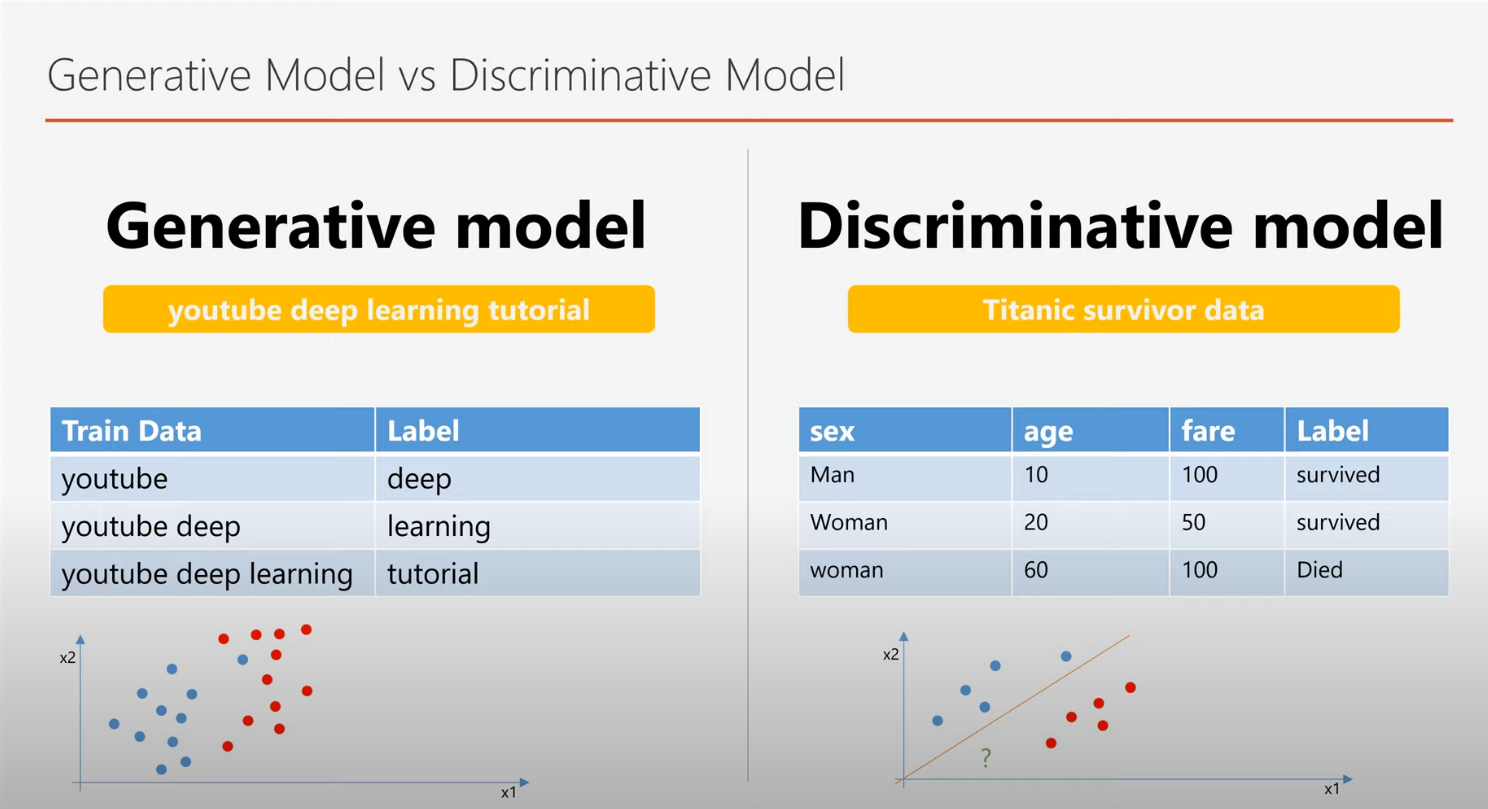

- Generative model, Discriminative model이 일반적으로 존재하는데 이때 Discriminative model을 우리가 일반적으로 사용하는 모델로 레이블링된 데이터가 존재하고 이를 통해 학습시키는 방식이다.하지만 이는 overfitting 문제로 쉽게 이어질 수 있다. 그에 비해 Generative model은 텍스트 하나만 가지고 그 뒤에 올 텍스트를 예측하는 것으로 레이블링이 필요없다. 하지만 학습 시간은 더 길어진다.
    
    
- GPT에서는 이중 Generative model 방법을 사용한다.

- Elon musk가 세운 비영리 연구기관 Open AI에서 나온 모델로 Transformer의 Decoder를 사용하여 만들어졌다.
    - 특징으로 `<S>`, `<E>`, $와 같은 special token을 도입하여 classification, entailment, similarity, multiple choice와 같은 다양한 task를 통합적으로 수행할 수 있는 모델이다.
        - 스폐셜 토큰으로는 문장의 시작을 알리는 start 토큰 `<s>`, 문장의 끝을 알리고 BERT의 CLS 토큰 역할을 하는 extract 토큰 `<e>`, BERT의 SEP 토큰처럼 문장을 이어주는 delimeter 토큰 `$`이 있다.
        
    - 즉, 다음에 올 단어를 예측하는 Languege model의 역할을 수행하면서 긍정, 부정인지 분류하는 task까지 동시에 수행할 수 있다.
    - 또한, 단어단위, 문장단위 모두 수행할 수 있다.
    - 다른 특징으론 pre-training 모델의 경우 label이 없는 self-supervised learning을 수행할 수 있고  fine-tuning 모델의 경우 task에 따른 label이 있어야 한다.
    
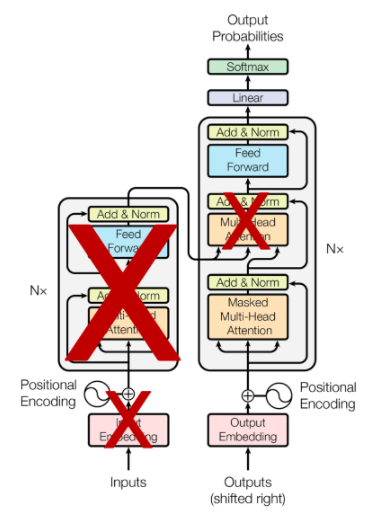

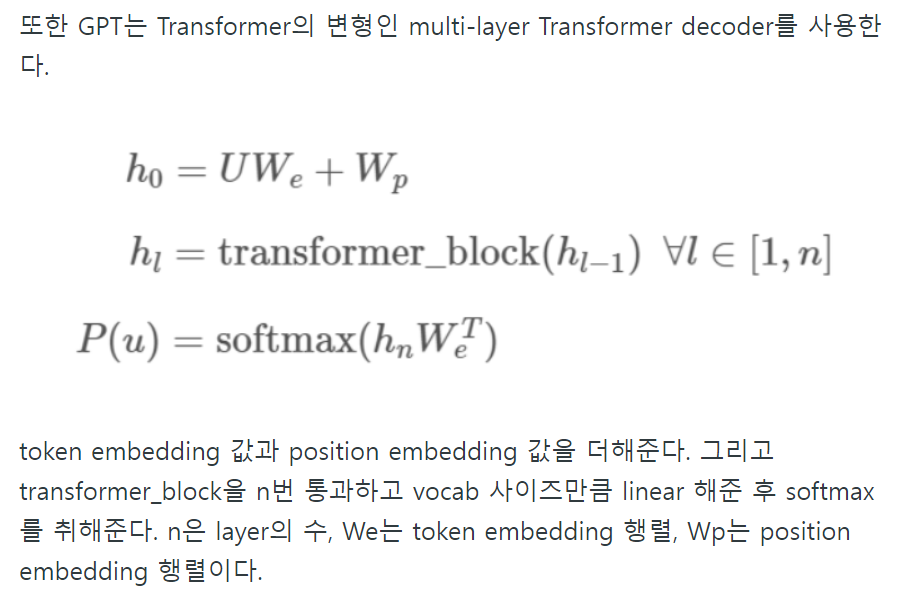

## Self_supervised_learning?

- 자기지도학습 이라고 번역된다.
- 예를들어 '너 어디 살아?' 라는 문장을 입력으로 받았을 때 해당 문장에 대한 Attntion과 Sentence Representation을 통해 다음에 어떤 단어가 최적의 단어일지 likelihood를 구해서 다음 단어를 prediction한다.
- 그로 인해 "Q: 너 어디 살아?' A: '나'" 라고 예측한다면 이후에 계속 likelihood를 구해 prediction한 단어를 내놓게 된다.

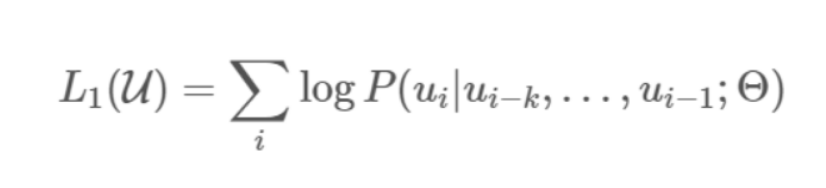

- k는 context window이고, Θ는 parameter이다.

### likelihood 예시
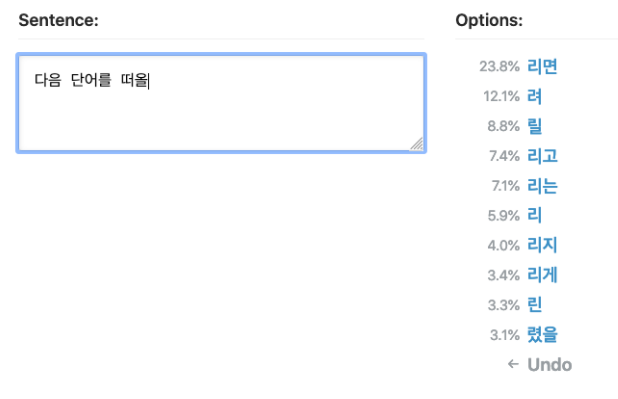

## GPT-1의 구조

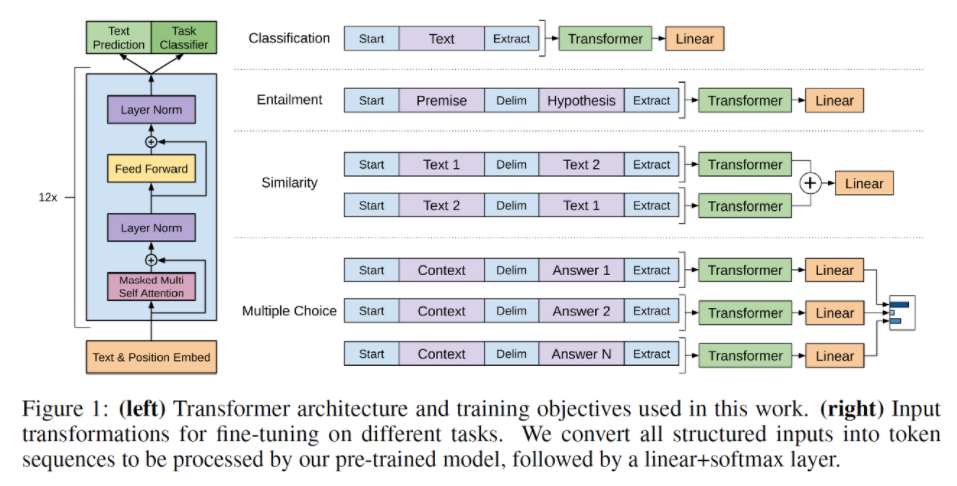

- task에 맞게 적절하게 input의 형태를 변형시켜주어야 한다.

## GPT-2의 구조

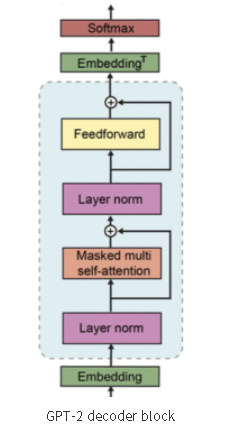


### GPT-1 과의 구조 차이
- normalization 레이어를 각 하위 블록의 입력으로 이동.
    
    
- residual layer의 깊이 N에 따라 $\frac{1}{\sqrt {N}} * weights$를 사용하여 residual layer의 가중치를 설정.
    
    
- 활성화함수를 relu가 아닌 gelu를 사용

## GPT-1 , GPT-2 의 구조 차이

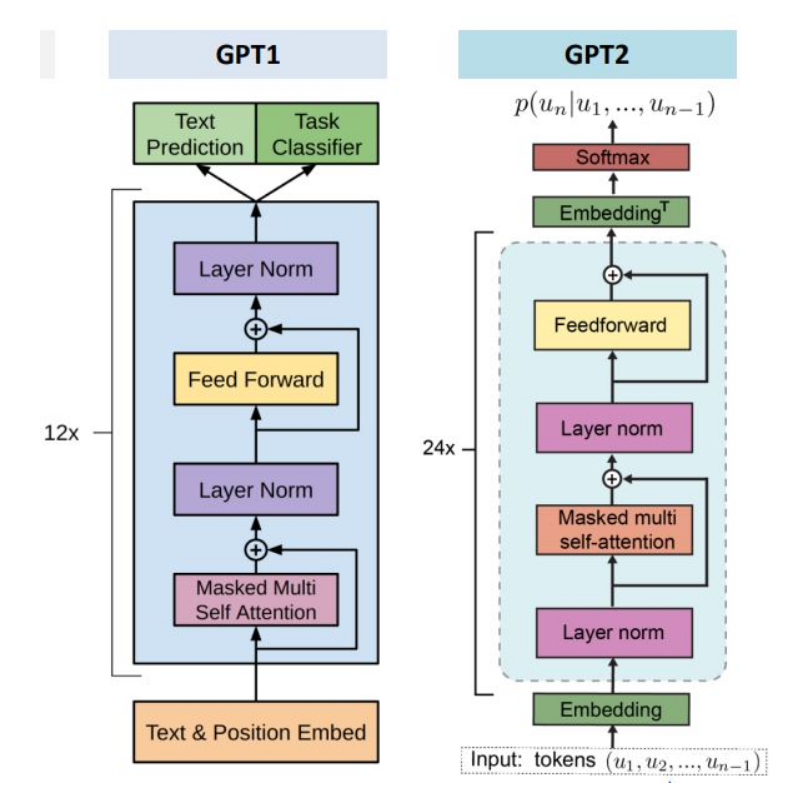

---

## 코드 리뷰

In [1]:
!pip install keras-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setup

In [2]:
import os
import keras_nlp
import tensorflow as tf
from tensorflow import keras

## Settings & hyperparameters

In [3]:
# Data
BATCH_SIZE = 64
SEQ_LEN = 128
MIN_TRAINING_SEQ_LEN = 450

# Model
EMBED_DIM = 256
FEED_FORWARD_DIM = 256
NUM_HEADS = 3
NUM_LAYERS = 2
VOCAB_SIZE = 5000  # 모델의 매개변수를 제한합니다.

# Training
EPOCHS = 6

# Inference
NUM_TOKENS_TO_GENERATE = 80

## 데이터 불러오기

이제 데이터 세트를 다운로드합시다! SimpleBooks 데이터 세트는 1,573권의 구텐베르크 책으로 구성되어 있으며 단어 수준 토큰 비율에 대한 가장 작은 어휘 크기 중 하나입니다. 어휘 크기는 WikiText-103의 1/3인 ∼98k이며 토큰 수는 거의 같습니다(∼100M). 이렇게 하면 작은 모델에 쉽게 맞출 수 있습니다.

In [4]:
keras.utils.get_file(
    origin="https://dldata-public.s3.us-east-2.amazonaws.com/simplebooks.zip",
    extract=True,
)
dir = os.path.expanduser("~/.keras/datasets/simplebooks/")

# simplebooks-92 train set를 로드하고 짧은 줄을 필터링합니다.
raw_train_ds = (
    tf.data.TextLineDataset(dir + "simplebooks-92-raw/train.txt")
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .batch(BATCH_SIZE)
    .shuffle(buffer_size=256)
)

# simplebooks-92 유효성 검사 세트를 로드하고 짧은 줄을 필터링합니다.
raw_val_ds = (
    tf.data.TextLineDataset(dir + "simplebooks-92-raw/valid.txt")
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .batch(BATCH_SIZE)
)

## 토크나이저 학습

조정된 하이퍼파라미터인 `VOCAB_SIZE`의 어휘 크기에 대해 훈련 데이터 세트에서 토크나이저를 훈련합니다. 어휘가 모델 매개변수의 수에 큰 영향을 미친다는 것을 나중에 알게 되므로 어휘를 최대한 제한하려고 합니다. 또한 우리는 너무 적은 어휘 용어를 포함하고 싶지 않습니다. 그렇지 않으면 어휘 외(OOV) 하위 단어가 너무 많을 것입니다. 또한 세 개의 토큰이 어휘에 예약되어 있습니다.:

- `SEQ_LEN`에 시퀀스를 패딩하기 위한 "[PAD]". WordPieceTokenizer(및 기타 레이어) 이후로 이 토큰은 reserved_tokens 및 vocab 모두에서 인덱스 0을 갖습니다.
- WordPieceTokenizer의 기본 oov_token="[UNK]"와 일치해야 하는 OOV 하위 단어의 "[UNK]".
- "[BOS]"는 문장의 시작을 의미하지만 여기서 기술적으로는 훈련 데이터의 각 행의 시작을 나타내는 토큰입니다.

In [5]:
# Train tokenizer vocabulary
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    raw_train_ds,
    vocabulary_size=VOCAB_SIZE,
    lowercase=True,
    reserved_tokens=["[PAD]", "[UNK]", "[BOS]"],
)

## 토크나이저 가져오기

어휘 데이터를 사용하여 keras_nlp.tokenizers.WordPieceTokenizer를 초기화합니다. WordPieceTokenizer는 BERT 및 기타 모델에서 사용하는 WordPiece 알고리즘을 효율적으로 구현한 것입니다. 소문자를 제거하고 다른 되돌릴 수 없는 전처리 작업을 수행합니다.

In [6]:
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    sequence_length=SEQ_LEN,
    lowercase=True,
)

## 데이터 토큰화

우리는 데이터셋을 `features` 와 `labels` 토큰화하고 분할하여 전처리합니다.

In [7]:
# 패커는 시작 토큰을 추가합니다.
start_packer = keras_nlp.layers.StartEndPacker(
    sequence_length=SEQ_LEN,
    start_value=tokenizer.token_to_id("[BOS]"),
)


def preprocess(inputs):
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels


# train and label 시퀀스로 토큰화하고 분할합니다.
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)
val_ds = raw_val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

## 모델 설계하기

다음 레이어로 축소된 GPT 모델을 생성합니다.:

- 하나의 `keras_nlp.layers.TokenAndPositionEmbedding` 레이어는 토큰의 임베딩과 위치를 결합합니다.
- 기본 인과 관계 마스킹이 있는 다중 keras_nlp.layers.TransformerDecoder 레이어. 
레이어는 디코더 시퀀스로만 실행될 때 cross-attention 없게 합니다.
- 하나의 최종 dense linear layer

In [8]:
inputs = keras.layers.Input(shape=(None,), dtype=tf.int32)
# Embedding.
embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=SEQ_LEN,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)
x = embedding_layer(inputs)
# Transformer decoders.
for _ in range(NUM_LAYERS):
    decoder_layer = keras_nlp.layers.TransformerDecoder(
        num_heads=NUM_HEADS,
        intermediate_dim=FEED_FORWARD_DIM,
    )
    x = decoder_layer(x)  # 하나의 인수를 제공하면 skips cross-attention.
# Output.
outputs = keras.layers.Dense(VOCAB_SIZE)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)
model.compile(optimizer="adam", loss=loss_fn, metrics=[perplexity])

모델 요약을 살펴보겠습니다. 대부분의 매개변수는 `token_and_position_embedding` 및 출력 `dense` 레이어에 있습니다!
이것은 어휘 크기(`VOCAB_SIZE`)가 모델의 크기에 큰 영향을 미치는 반면 Transformer 디코더 레이어(`NUM_LAYERS`)의 수는 그다지 영향을 미치지 않는다는 것을 의미합니다.

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_position_embeddin  (None, None, 256)        1312768   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_decoder (Transf  (None, None, 256)        394749    
 ormerDecoder)                                                   
                                                                 
 transformer_decoder_1 (Tran  (None, None, 256)        394749    
 sformerDecoder)                                                 
                                                                 
 dense (Dense)               (None, None, 5000)        128500

## 훈련

이제 모델이 있으므로 `fit()` 메서드를 사용하여 모델을 훈련해 보겠습니다.

In [10]:
model.fit(train_ds, validation_data=val_ds, verbose=2, epochs=EPOCHS)

Epoch 1/6
3169/3169 - 233s - loss: 4.5242 - perplexity: 97.7578 - val_loss: 3.9844 - val_perplexity: 61.3659 - 233s/epoch - 73ms/step
Epoch 2/6
3169/3169 - 228s - loss: 4.0084 - perplexity: 57.9975 - val_loss: 3.8523 - val_perplexity: 53.4342 - 228s/epoch - 72ms/step
Epoch 3/6
3169/3169 - 227s - loss: 3.8943 - perplexity: 51.6644 - val_loss: 3.8164 - val_perplexity: 51.4919 - 227s/epoch - 72ms/step
Epoch 4/6
3169/3169 - 228s - loss: 3.8319 - perplexity: 48.5014 - val_loss: 3.7649 - val_perplexity: 48.9244 - 228s/epoch - 72ms/step
Epoch 5/6
3169/3169 - 227s - loss: 3.7890 - perplexity: 46.4416 - val_loss: 3.7374 - val_perplexity: 47.5267 - 227s/epoch - 72ms/step
Epoch 6/6
3169/3169 - 227s - loss: 3.7570 - perplexity: 44.9621 - val_loss: 3.7159 - val_perplexity: 46.5195 - 227s/epoch - 72ms/step


## 추론

훈련된 모델을 사용하여 테스트하여 성능을 측정할 수 있습니다. 이 모델은 `"[BOS]"` 토큰으로 구축되었으므로 텍스트 생성을 위한 빈 시작 프롬프트를 가질 수 있습니다.

In [11]:
# Unpadded bos token.
prompt_tokens = tf.convert_to_tensor([tokenizer.token_to_id("[BOS]")])

추론을 위해 `keras_nlp.utils` 모듈을 사용합니다. 모든 텍스트 생성 유틸리티에는 모델 주위에 `token_logits_fn()` 래퍼가 필요합니다. 이 래퍼는 패딩되지 않은 토큰 시퀀스를 사용하며 다음 토큰의 로지트를 출력으로 요구합니다.

Note : [logit이 무엇일까？](https://i-am-eden.tistory.com/21)

In [12]:

def token_logits_fn(inputs):
    cur_len = inputs.shape[1]
    output = model(inputs)
    return output[:, cur_len - 1, :]  # return next token logits


래퍼 함수를 ​​만드는 것은 이러한 함수를 사용하는 데 있어 가장 복잡한 부분입니다. 완료되었으므로 greedy search부터 시작하여 다양한 유틸리티를 테스트해 보겠습니다.

### Greedy search

각 타임스텝에서 가장 가능성이 높은 토큰을 탐욕스럽게 선택합니다. 즉, 모델 출력의 argmax를 얻습니다.

In [13]:
output_tokens = keras_nlp.utils.greedy_search(
    token_logits_fn,
    prompt_tokens,
    max_length=NUM_TOKENS_TO_GENERATE,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Greedy search generated text: \n{txt}\n")

Greedy search generated text: 
b'[BOS] " i don \' t know what i can do , " said the old man , " and he is going to be a little more than a little older than he is . he is a little older than himself , and he is a little older than himself . he is a little older than himself , and he is very fond of him , and he is very fond of him . he is very'



보시다시피 탐욕적인 검색은 어느 정도 이해가 되기 시작하지만 빠르게 반복되기 시작합니다. 이것은 나중에 보게 될 일부 확률적 텍스트 생성 유틸리티로 해결할 수 있는, 텍스트 생성의 일반적인 문제입니다!

### Beam search

높은 수준에서 빔 검색은 각 타임스텝에서 `num_beams` 개의 가장 가능성 있는 시퀀스를 추적하고 모든 시퀀스에서 가장 좋은 다음 토큰을 예측합니다. 그것은 더 많은 가능성을 저장하기 때문에 탐욕적인 검색보다 개선된 것입니다. 그러나 다중 잠재적 시퀀스를 계산하고 저장해야 하므로 Greedy Search보다 효율성이 떨어집니다.

**참고** : `num_beams=1` 인 빔 검색은 욕심 많은 검색과 동일합니다.

In [14]:
output_tokens = keras_nlp.utils.beam_search(
    token_logits_fn,
    prompt_tokens,
    max_length=NUM_TOKENS_TO_GENERATE,
    num_beams=10,
    from_logits=True,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Beam search generated text: \n{txt}\n")

Beam search generated text: 
b'[BOS] " i don \' t know what to do , " he said . " i don \' t know what to do . i don \' t know what to do , but i don \' t know what to do . i don \' t know what to do . i don \' t know what to do , but i don \' t know what to do . i don \' t know what to do'



Greedy search 와 유사하게 Beam search 는 여전히 ​​결정론적 방법이기 때문에 빠르게 반복되기 시작합니다.

### Random search

무작위 검색은 첫 번째 확률적 방법입니다. 각 time step에서 모델에서 제공하는 softmax 확률을 사용하여 다음 토큰을 샘플링합니다.

In [15]:
output_tokens = keras_nlp.utils.random_search(
    token_logits_fn,
    prompt_tokens,
    max_length=NUM_TOKENS_TO_GENERATE,
    from_logits=True,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Random search generated text: \n{txt}\n")

Random search generated text: 
b"[BOS] don so that i , you see ; tell the story , and now that it is now quite prepared to stop , if the old man himself , and so he is lifted on his knees and hands , and gets some not of them ; and then he bones , and shaped another hole ; and , he put the wolf ' s head off up , and put the arab he shall be br"



짜잔, 반복이 없습니다! 그러나 Random search를 사용하면 어휘의 모든 단어가 이 샘플링 방법으로 나타날 가능성이 있기 때문에 일부 무의미한 단어가 나타나는 것을 볼 수 있습니다.
것은 다음 검색 유틸리티인 top-k 검색으로 해결합니다.

### Top-K search

Random search와 마찬가지로 모델에서 제공하는 확률 분포에서 다음 토큰을 샘플링합니다. 유일한 차이점은 여기에서 가장 가능성이 높은 상위 `k`개의 토큰을 선택하고 샘플링 전에 확률 질량을 분산한다는 것입니다.
이렇게 하면 확률이 낮은 토큰에서 샘플링하지 않으므로 무의미한 단어가 줄어듭니다!

In [16]:
output_tokens = keras_nlp.utils.top_k_search(
    token_logits_fn,
    prompt_tokens,
    max_length=NUM_TOKENS_TO_GENERATE,
    k=10,
    from_logits=True,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-K search generated text: \n{txt}\n")

Top-K search generated text: 
b"[BOS] it was not long after a little , when one of the children ' s father had been born in the world , or he had no other children , and was not a man . they had never before lived in the land of the green forest , when he saw how the old farmer ' s boy lived in the land , and said he was going into a big place . so he was sure that"



### Top-P search

top-k 검색에서도 개선할 점이 있습니다. top-k 검색을 사용하면 숫자 `k`가 고정됩니다. 즉, 모든 확률 분포에 대해 동일한 수의 토큰을 선택합니다. 확률 질량이 2개 단어에 집중되는 시나리오와 확률 질량이 10개 단어에 균등하게 집중되는 시나리오 두 가지를 고려할 수 있습니다. 
우리는 k=2 또는 k=10 어느것을 선택해야 할까요 ? 여기에 모든 `k`에 맞는 하나의 크기는 없습니다.

이것이 top-p 검색이 나올 때입니다! k를 선택하는 대신 상위 토큰의 확률을 합산하려는 확률 p를 선택합니다. 이렇게 하면 확률 분포에 따라 k를 동적으로 조정할 수 있습니다. p=0.9로 설정하면 확률 질량의 90%가 상위 2개 토큰에 집중되는 경우 샘플링할 상위 2개 토큰을 필터링할 수 있습니다. 만약 90%가 10개의 토큰에 분산되면 마찬가지로 샘플링할 상위 10개의 토큰을 필터링합니다.

In [17]:
output_tokens = keras_nlp.utils.top_p_search(
    token_logits_fn,
    prompt_tokens,
    max_length=NUM_TOKENS_TO_GENERATE,
    p=0.5,
    from_logits=True,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")

Top-P search generated text: 
b'[BOS] when the skater of the stream is seen to electrons which is about two , the little squadron of the second plate is so that it is almost like a tube of a plate circuit and with the plate plate which is circuit . the plate is used by the plate current plate current is c plate plate 2 plate plate 2 between plate 2'



### 텍스트 생성을 위한 콜백 사용

또한 유틸리티를 콜백으로 래핑하여 모델의 모든 에포크에 대한 예측 시퀀스를 출력할 수 있습니다! 다음은 top-k 검색에 대한 콜백의 예입니다. :

In [18]:

class TopKTextGenerator(keras.callbacks.Callback):
    """top-k를 사용하여 훈련된 모델에서 텍스트를 생성하는 콜백입니다."""

    def __init__(self, k):
        self.k = k

    def on_epoch_end(self, epoch, logs=None):
        output_tokens = keras_nlp.utils.top_k_search(
            token_logits_fn,
            prompt_tokens,
            max_length=NUM_TOKENS_TO_GENERATE,
            k=self.k,
            from_logits=True,
        )
        txt = tokenizer.detokenize(output_tokens)
        print(f"Top-K search generated text: \n{txt}\n")


text_generation_callback = TopKTextGenerator(k=10)
# 콜백을 시연하기 위한 더미 훈련 루프.
model.fit(train_ds.take(1), verbose=2, epochs=2, callbacks=[text_generation_callback])

Epoch 1/2
Top-K search generated text: 
b'[BOS] now he must go with his horse , when he saw the white man coming back and coming toward him . he would see his head and see what he could see and how beautiful he could see ? how was he he ? he would have to come back to the place where king arthur would come and help him as he could . and then he would come and be sure that he would see all the'

1/1 - 7s - loss: 3.8809 - perplexity: 49.1504 - 7s/epoch - 7s/step
Epoch 2/2
Top-K search generated text: 
b'[BOS] " it has been very good to you , " said he , as he stooped , " that you may make a mistake of your getting out into your head . i don \' t suppose i \' m going to give my advice and take my advice as well as i can . if you can get a letter from you would have been written by mr . penfold , and he will tell'

1/1 - 7s - loss: 3.7166 - perplexity: 42.9962 - 7s/epoch - 7s/step


## 결론

요약하자면, 이 예시에서는 KerasNLP 레이어를 사용하여 하위 단어 어휘를 훈련하고, 훈련 데이터를 토큰화하고, 미니어처 GPT 모델을 만들고, 텍스트 생성 라이브러리로 추론을 수행합니다.

Transformers의 작동 방식을 이해하거나 전체 GPT 모델 학습에 대해 자세히 알아보려면 다음을 참고하세요.:

- Attention Is All You Need [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
- GPT-3 Paper [Brown et al., 2020](https://arxiv.org/abs/2005.14165)

## 회고

```
GPT 모델이라서 어려울 것이라 생각했는데, 선정한 주제의 컨텐츠 대부분이 Keral-NLP 에서 제공하는 레이어를 사용하여, 
데이터들을 토큰화 하고 텍스트 생성을 해 보는 내용으로, GPT의 작동방식이나 모델에 대해서 깊에 알아보는 구성은 아니었다.
GPT 입문단계에 흥미를 가져올 수 있는 적당한 코드이며, 유사한 미니어쳐 모델들을 통해 텍스트 생성에 대한 아이디어를 얻을 수 있는 시간이었다.
```

## Reference

- [GPT란?](https://sooftware.io/gpt/)
- [GPT의 구조](https://velog.io/@seven7724/GPT12)